In [3]:
import numpy as np
import burst_detector as bd
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import burst_detector as bd
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
from torch.profiler import profile, record_function, ProfilerActivity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy.spatial.distance as dist
from sklearn.neighbors import NearestNeighbors

In [5]:
n_chan = 385

ks_dir = "../data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/imec0_ks2/"

times = np.load(os.path.join(ks_dir, "spike_times.npy")).flatten()
clusters = np.load(os.path.join(ks_dir, "spike_clusters.npy")).flatten()

counts = bd.spikes_per_cluster(clusters)
cl_labels = pd.read_csv(os.path.join(ks_dir, "cluster_group.tsv"), sep="\t", index_col=False)
times_multi = bd.find_times_multi(times, clusters, np.arange(clusters.max()+1))

channel_pos = np.load(os.path.join(ks_dir, "channel_positions.npy"))
channel_map = np.load(os.path.join(ks_dir, "channel_map.npy")).flatten()
mean_wf = np.load(os.path.join(ks_dir, "mean_waveforms.npy"))
peak_chans = np.argmax(np.max(mean_wf, 2) - np.min(mean_wf,2),1)

channel_shanks = (channel_pos[:,0]/250).astype("int")
templates = np.load(os.path.join(ks_dir, "templates.npy"))

# load raw data
rawData = np.memmap("C:/Users/Harris_Lab/Projects/burst-detector/data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/rec_bank0_dense_g0_tcat.imec0.ap.bin", dtype='int16', mode='r')
data = np.reshape(rawData, (int(rawData.size/n_chan), n_chan))

In [6]:
params = {}

params["data_filepath"] = "C:/Users/Harris_Lab/Projects/burst-detector/data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/rec_bank0_dense_g0_tcat.imec0.ap.bin"
params["KS_folder"] =  "../data/rec_bank0_dense_g0/KS2.5/catgt_rec_bank0_dense_g0/rec_bank0_dense_g0_imec0/imec0_ks2/"

params["calc_means"] = False
params["fs"] = 30000
params["n_chan"] = 385
params["pre_samples"] = 20
params["post_samples"] = 62
params["max_spikes"] = 2000

params["skip_cross_sim"] = False

params["jitter"] = False
params["jitter_amt"] = 4
params["sim_thresh"] = 0.4
params["min_spikes"] = 100

params["n_iter"] = 50
params["shuffle_bin_width"] = 0.1
params["window_size"] = 0.025
params["xcorr_bin_width"] = 0.001
params["overlap_tol"] = 10/30000
params["max_window"] = 0.01
params["min_xcorr_rate"] = 800

params["xcorr_ref_p"] = 0.001
params["ref_pers"] = [0.002]
params["max_viol"] = 0.01

params["xcorr_coeff"] =  0.5
params["ref_pen_coeff"] = 1
params["final_thresh"] = 0.7
params["max_dist"] = 10

In [7]:
ci = {
    'times': times,
    'times_multi': times_multi,
    'clusters': clusters,
    'counts': counts,
    'labels': cl_labels,
    'mean_wf': mean_wf
}
gti = {
    'spk_fld': r"C:\Users\Harris_Lab\Projects\burst-detector\data\rec_bank0_dense_g0\KS2.5\catgt_rec_bank0_dense_g0\rec_bank0_dense_g0_imec0\imec0_ks2\automerge\spikes",
    'pre_samples': 10,
    'post_samples': 30,
    'num_chan': 8,
    'noise': False,
    'for_shft': False
}
bd.generate_train_data(data, ci, channel_pos, gti, params)

In [ ]:
net, spk_data = bd.train_ae(gti['spk_fld'], counts, num_epochs=5)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
spk_data = bd.autoencoder.SpikeDataset(os.path.join(gti['spk_fld'], "labels.csv"), gti['spk_fld'], ToTensor())
net = bd.autoencoder.CN_AE().to(device)
net.load_state_dict(torch.load('./models/bijan_vn_15d_balanced.pt'))
net.eval();

In [17]:
chans = {}

for i in range(mean_wf.shape[0]):
    if i in counts:
        chs, peak = bd.utils.find_best_channels(mean_wf[i], channel_pos, 8)
        dists = bd.utils.get_dists(channel_pos, peak, chs)
        chans[i] = chs[np.argsort(dists)].tolist()

In [18]:
n_clust = clusters.max() + 1
cl_good = np.zeros(n_clust, dtype=bool)
unique = np.unique(clusters)
for i in range(n_clust):
     if (i in unique) and (counts[i] > params['min_spikes']) \
        and (cl_labels.loc[cl_labels['cluster_id']==i, 'group'].item() == 'good'):
            cl_good[i] = True

In [20]:
ae_sim, spk_lat_peak, lat_mean, spk_lab = bd.stages.calc_ae_sim(mean_wf, net, peak_chans, spk_data, chans, cl_good)

1566
LOSS: 25.31591516432674


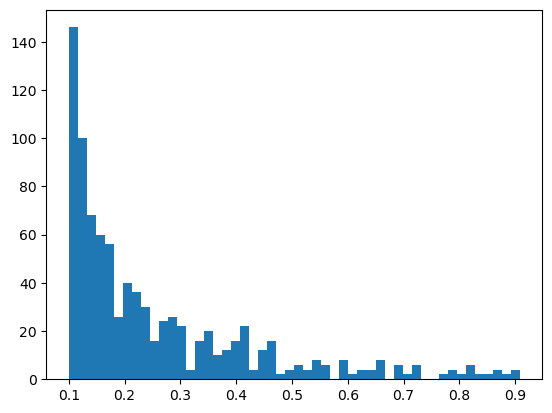

In [21]:
plt.hist(ae_sim.flatten()[ae_sim.flatten() > .1], bins=50);